# A step-by-step illustration of the algorithm
This script illustrates the steps of calculating catchmentwide erosion rates with the `riversand` package. It shows all the basic calculations performed by the functions `.process_single_catchment()`and `.process_multi_catchment()`, which iterate over samples and catchments and save plots and results.

Use this script for a better understanding of the algorithm, or if you want to develop your own customized script for calculating catchmentwide erosion rates.

This script uses the example datasets in the folder `test_data/`.

## Test dataset
The coloring in this image represents a (hypothetical) distribution of quartz-bearing (blue) and quartz-free (red) lithologies. The shapefile has 8 polygons; we will be using the polygon in the western part of the map (yellow outline).  
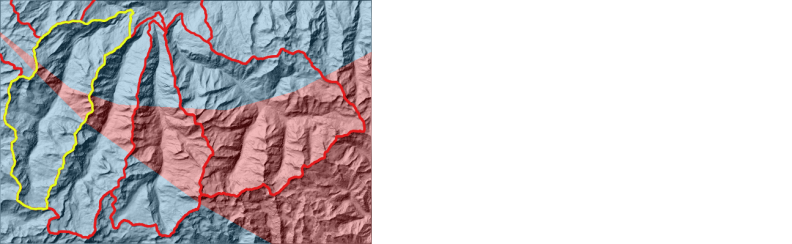

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import riversand
from riversand.params import units

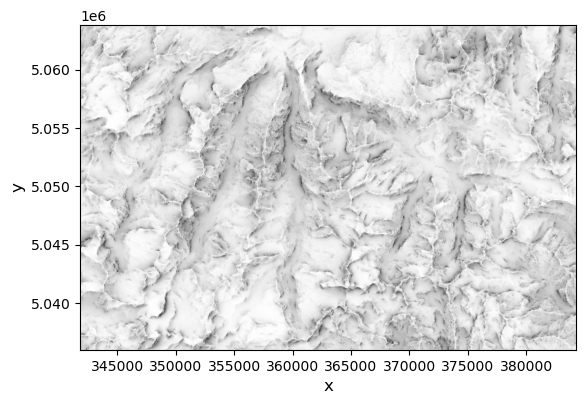

In [2]:
rv = riversand.Riversand("./test_data")

# raster data
rv.add_raster('dem_utm_35m.tif', dtype='elevation')
rv.add_raster('toposhielding_35m.tif', dtype='shielding')
rv.add_raster('quartz_35m.tif', dtype='quartz')

riversand.plot_raster(rv,
                      dtype='shielding', # plot the shielding raster
                      fname='show')      # display; other options are 'jpg' or 'png'

In [3]:
# sample data
rv.add_samples({'N':2.0e4, 'delN': 6.0e2, 'nuclide': 'Be-10'})
rv.add_samples({'N':1.2e5, 'delN': 3.6e3, 'nuclide': 'Al-26'}, add=True)
rv.add_samples({'N':2.0e4, 'delN': 3.0e3, 'nuclide': 'Be-10'}, add=True)
rv.samples

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,600,07KNSTD
1,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000,3600,KNSTD
2,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,3000,07KNSTD


In [4]:
# catchment polygons
rv.add_catchments('test_multi_catchment.shp')
rv.set_cid('name')
rv.catchments.get_names()

['DB02', 'DB03', 'DB04', 'DB05', 'DB12', 'DB12', 'DB17', 'DB19']

In [5]:
# all samples are named 'Test', there are no matches with the shapefile polygons
rv.validate()


Raster data valid
Sample data valid
Catchment data valid

Valid catchments / samples:
   No matches found


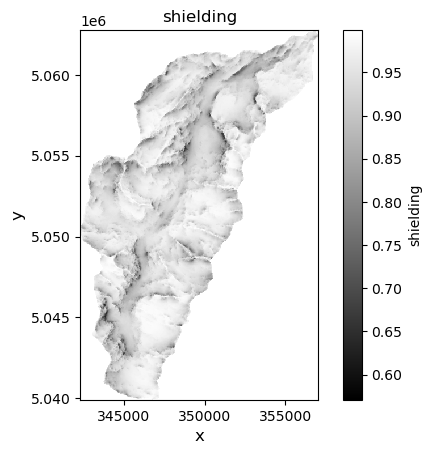

In [6]:
# clip the desired catchment, which happens to be the number n=5 (trial and error...)
clips = rv.clip_all_rasters(n=5)
riversand.plot_clipped_raster(clips,
                              dtype='shielding', # plot the clipped shielding raster
                              fname='show')      # display; other options are 'jpg' or 'png'

In [7]:
# remove the quartz-free areas
clips = riversand.eliminate_quartzfree(clips)

Removed 8.4 % of the catchment as quartz-free


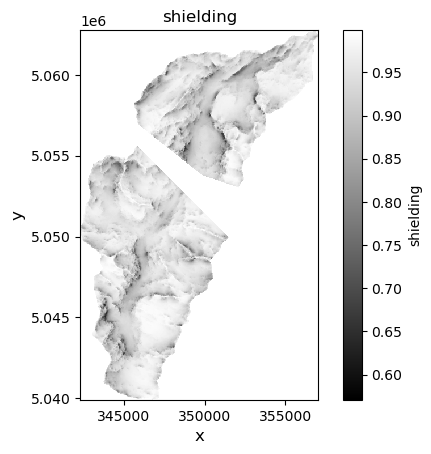

In [8]:
# note that the quartz-free parts of the catchment are now removed
riversand.plot_clipped_raster(clips,
                              dtype='shielding',
                              fname='show')

In [9]:
# define parameters for the calculation
bins = 250
scaling = 'LSDn'
shielding = 'topo'
unit = 'cm/kyr'

In [10]:
# compute elevation statistics
topostats, summary = riversand.get_topostats(clips, bins=bins, centroid='from_clipped')
topostats.head()

,bin,elevation,shielding,area,lat,long,wt
0,500.0,732.931641,0.951597,0.143325,45.607522,7.054166,0.000989
1,750.0,904.356750,0.941359,1.201725,45.607522,7.054166,0.008289
2,1000.0,1149.900879,0.922780,2.447550,45.607522,7.054166,0.016882
3,1250.0,1375.429321,0.914356,4.370800,45.607522,7.054166,0.030147
4,1500.0,1636.551636,0.916487,10.071950,45.607522,7.054166,0.069471


In [11]:
# summary has the 35, 50 and 65 percentile elevations and the centroid latitude and longitude of the catchment
summary

{'elevLo': 2274.0,
 'elev50': 2484.0,
 'elevHi': 2688.0,
 'lat': 45.60752151115545,
 'long': 7.054166221307744,
 'areakm2': 144.9812,
 'shielding': 0.9313201,
 'quartz': 0.9161506,
 'epsg': 32632}

## First sample: Be-10

In [12]:
rv.samples

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,600,07KNSTD
1,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000,3600,KNSTD
2,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,3000,07KNSTD


In [13]:
# select a row from the sample data
i = 0 # first row 
sample_data = rv.samples.iloc[i] 

In [14]:
# use the elevation statistics summary to estimate a probable range of erosion rates
# minimum estimate from 1st quartile of elevations
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
E_Lo

{'St': 0.07440000000000001,
 'Lm': 0.07636603773584906,
 'LSDn': 0.08048301886792453}

In [15]:
# maximum estimate from 3rd quartile of elevations
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
E_Hi

{'St': 0.09655094339622641,
 'Lm': 0.09950566037735849,
 'LSDn': 0.10743773584905661}

In [16]:
# generate suitable initial erosion rates (scaling-specific)
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr
erates

array([0.08048302, 0.08526971, 0.09034108, 0.09571408, 0.10140663,
       0.10743774])

In [17]:
# perform the polynomial fitting
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))

In [18]:
E, delE # erosion rate and uncertainty in cm/yr

(0.09421574755709135, (0.0028012972365257655, 0.0029696245081824724))

In [19]:
NofE # nuclide concentrations for the inital erosion rates determined by the online calculator

E_cmyr
0.08048    23320.538687
0.08527    22045.866944
0.09034    20838.844845
0.09571    19694.500344
0.10140    18607.289074
0.10740    17578.226297
Name: LSDn, dtype: float64

In [20]:
err # error message

[]

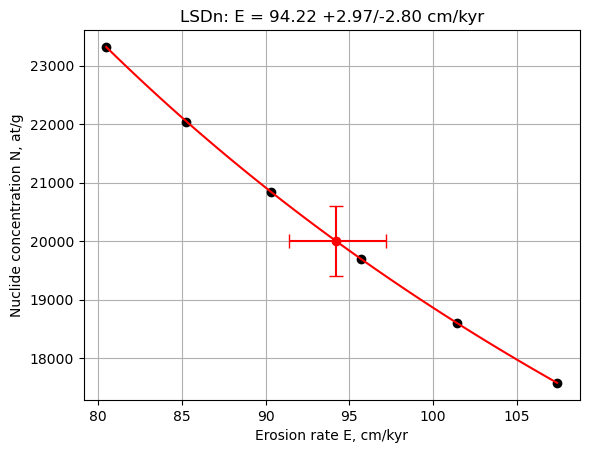

In [21]:
# plot the results
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

- The black points are the erosion rates `erates` sent to the server and the corresponding predicted nuclide concentrations `NofE`.
- The red curve is the polynomial fit to `NofE`
- The red point and vertical error bar are the nuclide concentration of the sample `sample_data['N']` and uncertainty `sample_data['delN']`
- The horizontal error bar is the uncertainty on the erosion rate `delE` resulting from the analytics uncertainty `delN`; it depends on the shape of the function $N(E)$ and is therefore asymmetric. Use the upper value (`delE[1]`) for a more conservative estimate of the analytical uncertainty in `E`.

In [22]:
# print the result E, delE[1] in a pretty format
u = units[unit]
print("{} : {:.1f} +/-{:.1f} {}".format(sample_data['nuclide'], E*u, delE[1]*u, unit))

Be-10 : 94.2 +/-3.0 cm/kyr


## Second sample: Al-26

In [23]:
rv.samples

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,600,07KNSTD
1,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000,3600,KNSTD
2,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,3000,07KNSTD


In [24]:
# select a row from the sample data
i = 1 # second row 
sample_data = rv.samples.iloc[i]

In [25]:
# generate initial erosion rates
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr

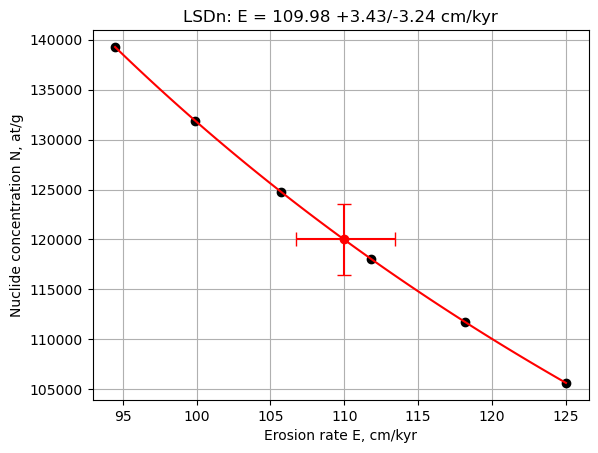

In [26]:
# perform the polynomial fitting and plot results
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

In [27]:
print("{} : {:.1f} +/-{:.1f} {}".format(sample_data['nuclide'], E*u, delE[1]*u, unit))

Al-26 : 110.0 +/-3.4 cm/kyr


## Third sample: Be-10 with a 5 times higher uncertainty than first sample

In [28]:
rv.samples

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,600,07KNSTD
1,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000,3600,KNSTD
2,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,3000,07KNSTD


In [29]:
# select a row from the sample data
i = 2 # third row 
sample_data = rv.samples.iloc[i]

In [30]:
# generate initial erosion rates
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr

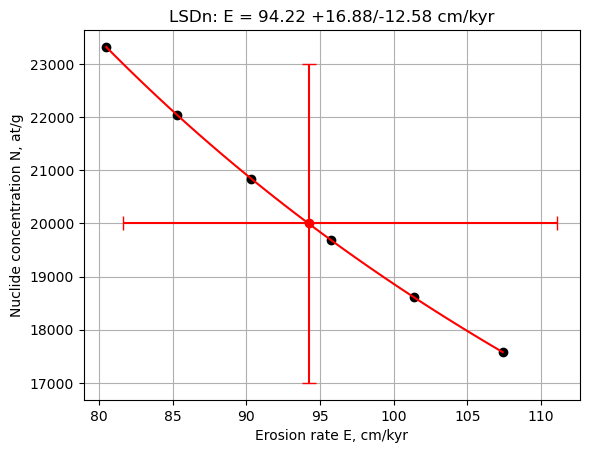

In [31]:
# perform the polynomial fitting and plot results
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

In [32]:
print("{} : {:.1f} +/-{:.1f} {}".format(sample_data['nuclide'], E*u, delE[1]*u, unit))

Be-10 : 94.2 +/-16.9 cm/kyr


## Finally
The functions `.process_single_catchment()`and `.process_multi_catchment()` optimize the choice of a suitable set of initial erosion rates `erates`. You can customize the initial erosion rates, even though this is generally not necessary or even useful:

In [33]:
sample_data = rv.samples.iloc[0]

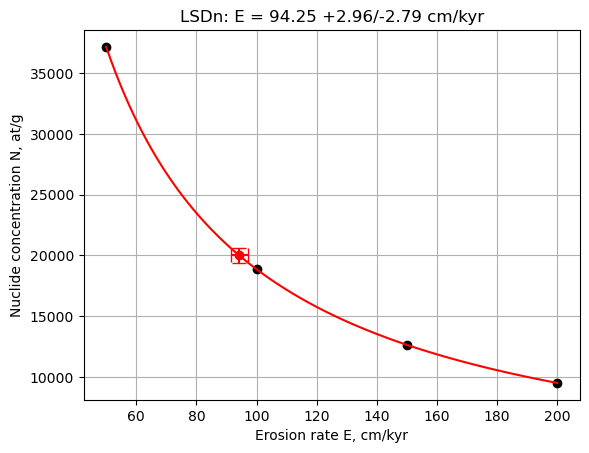

In [34]:
# (1) Custom initial erosion rates:
unit = 'cm/kyr'
erates = [0.05, 0.10, 0.15, 0.20] # cm/yr
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

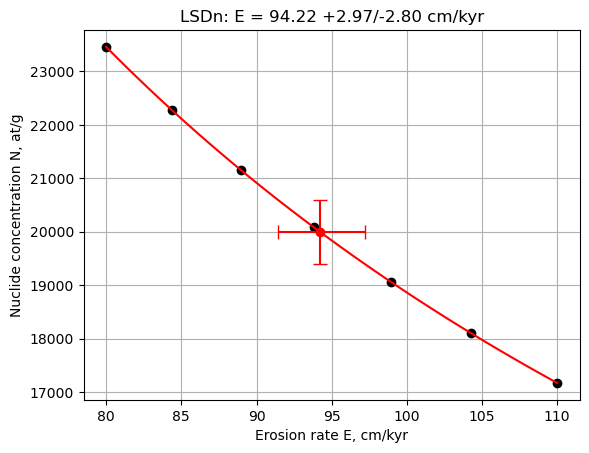

In [35]:
# (2) Using the function .guess_erates() for logarithmically distributed values
erates = riversand.guess_erates(0.08, 0.11, N=7)
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

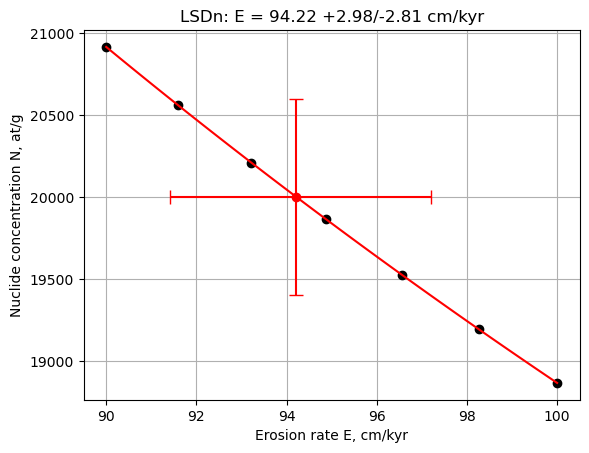

In [36]:
# (3) Using narrower brackets 
erates = riversand.guess_erates(0.09, 0.10, N=7)
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

In [37]:
# (4) Note that you may get error messages for an unsuitable choice of initial erosion rates
erates = riversand.guess_erates(0.08, 0.09, N=5)
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
err

['maxE too low']

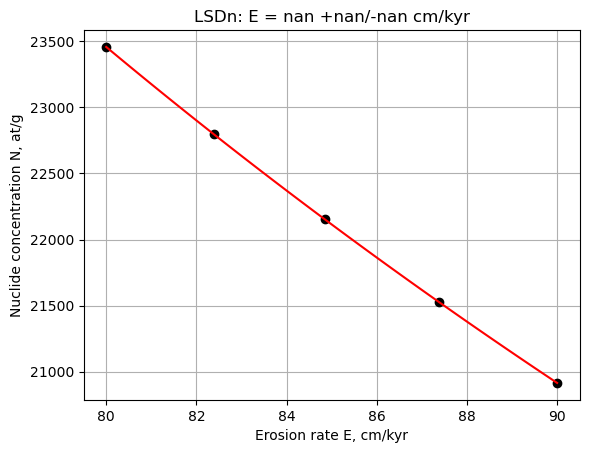

In [38]:
# erosion rate is outside of the range of NofE: nothing much to plot
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

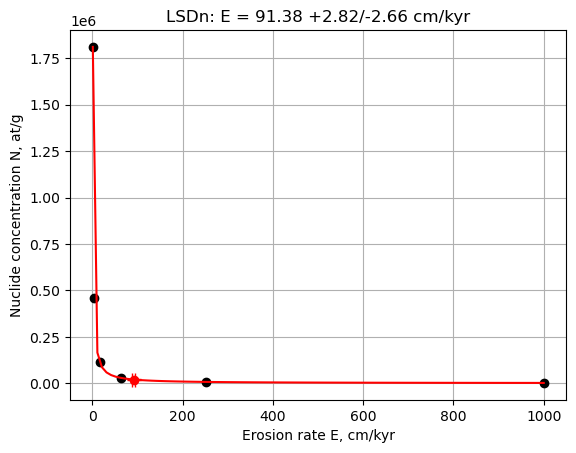

In [39]:
# (5) Unsuitable initial erosion rates may also result in a poor fit of the polynomial function
erates = riversand.guess_erates(0, 1)
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

#NRMSE = riversand.get_RMSE(NofE)/sample_data['N']

In [40]:
err

['NRMSE = 3.16e-02 suggests a poor fit of the polynomial']

## Extremely high and very low erosion rates
The algorithm becomes unstable for extremely low and extremely high nuclide concentrations; try the following code with concentrations of **N = 100 atoms/gram** or **N = 5E+7 atoms/gram**. It is, of course, highly questionable that such nuclide concentrations reflect a catchmentwide erosion rate...

In [41]:
#extremely low nuclide concentrations:
sample_data = {'N': 5e7, 'delN': 1e6}

# generate initial erosion rates
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr

unit = 'mm/kyr'
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

RuntimeError: get_E() : sample appears to be saturated